<a href="https://colab.research.google.com/github/kgoldra/capstone_Xplisit/blob/main/ML/nailornot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import zipfile
import os
import shutil
import random
from shutil import copyfile
import cv2
import numpy as np
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from google.colab import files
from sklearn.utils import class_weight
from tensorflow.keras.optimizers import RMSprop

In [2]:
try:
  shutil.rmtree('/content/nailornot')
  shutil.rmtree('/content/Data')
  shutil.rmtree('/content/test')
except:
  pass

In [3]:
path_nails = f"/content/nailornot.zip"

local_zip = path_nails
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/')
zip_ref.close()

In [4]:
ORIGINDIR = "/content/nailornot"
DATADIR = "/content/Data"
TRAINORTEST = ["training", "testing"]
CATEGORIES = ["nails","notnails"]

In [5]:
counter = 0

for trainortest in TRAINORTEST:
  path = os.path.join(DATADIR, trainortest)
  for category in CATEGORIES:
    counter += 1
    originpath = os.path.join(ORIGINDIR, category)
    path2 = os.path.join(path, category)
    if(counter) <= 2:
      print(category, "Datasets Has: ", len(os.listdir(originpath)) ,"Data")
    os.makedirs(path2)
    pass

nails Datasets Has:  840 Data
notnails Datasets Has:  769 Data


In [6]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")
    
    training_sets = int(len(files) * SPLIT_SIZE)
    testing_sets = int(len(files) - training_sets)
    randomed = random.sample(files,len(files))
    training_files = randomed[0:training_sets]
    testing_files = randomed[:testing_sets]
    
    for filename in training_files:
        source = SOURCE + filename
        destination = TRAINING + filename
        copyfile(source, destination)
        
    for filename in testing_files:
        source = SOURCE + filename
        destination = TESTING + filename
        copyfile(source, destination)

In [7]:
nails_DIR = "/content/nailornot/nails/"
TRAINING_nails_DIR = "/content/Data/training/nails/"
TESTING_nails_DIR = "/content/Data/testing/nails/"

notnails_DIR = "/content/nailornot/notnails/"
TRAINING_notnails_DIR = "/content/Data/training/notnails/"
TESTING_notnails_DIR = "/content/Data/testing/notnails/"


split_size = .9




split_data(nails_DIR, TRAINING_nails_DIR, TESTING_nails_DIR, split_size)
split_data(notnails_DIR, TRAINING_notnails_DIR, TESTING_notnails_DIR, split_size)

In [8]:
IMGSIZE = 256

In [9]:
TRAINING_DIR = "/content/Data/training"
training_datagen = ImageDataGenerator(
      rescale = 1.0/255.)

VALIDATION_DIR = "/content/Data/testing"
validation_datagen = ImageDataGenerator(rescale = 1.0/255.)

train_generator = training_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(IMGSIZE,IMGSIZE),
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(IMGSIZE,IMGSIZE),
    class_mode='binary'
)

Found 1448 images belonging to 2 classes.
Found 161 images belonging to 2 classes.


In [10]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam


# Pretrained Model + Fine Tuning (https://keras.io/api/applications/)
# create the base pre-trained model : Xception + global spatial average pooling
base_model = Xception(weights='imagenet', input_shape = (IMGSIZE,IMGSIZE,3), include_top=False, pooling = 'avg')

# add a global spatial average pooling layer
x = base_model.output
# let's add a fully-connected layer
x = Dense(256, activation='relu')(x)
# and a logistic layer -- 18 classes
predictions = Dense(1, activation='sigmoid')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
opt = Adam(lr=0.001, decay = 1e-6, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics = ['accuracy'])

# train the model on the new data for a few epochs
model.fit(train_generator, epochs=4, validation_data = validation_generator, verbose = 1)

# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from Xception. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

# we chose to train the last inception blocks, i.e. we will freeze
# the first 125 layers and unfreeze the rest:
for layer in model.layers[:125]:
    layer.trainable = False
for layer in model.layers[125:]:
    layer.trainable = True
# we need to recompile the model for these modifications to take effect
model.compile(optimizer=opt, loss='binary_crossentropy', metrics = ['accuracy'])

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
history = model.fit(
    train_generator, 
    epochs=2, 
    validation_data = validation_generator, 
    verbose = 1
    )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/4
46/46 [==============================] - 391s 8s/step - loss: 0.0261 - accuracy: 0.9903 - val_loss: 3.4408e-05 - val_accuracy: 1.0000
Epoch 2/4
46/46 [==============================] - 381s 8s/step - loss: 2.8645e-05 - accuracy: 1.0000 - val_loss: 2.6811e-05 - val_accuracy: 1.0000
Epoch 3/4
46/46 [==============================] - 375s 8s/step - loss: 2.4068e-05 - accuracy: 1.0000 - val_loss: 2.3265e-05 - val_accuracy: 1.0000
Epoch 4/4
46/46 [==============================] - 379s 8s/step - loss: 2.0798e-05 - accuracy: 1.0000 - val_loss: 2.0343e-05 - val_accuracy: 1.0000
0 input_1
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d
13 block2_pool
14 batch_normalization
15 add
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_1
2

In [11]:
model.save("model_xception_nails_v2.h5")
#convert to json
model_json = model.to_json()
with open("model.json", "w") as json_file:
  json_file.write(model_json)

model.save_weights("weight.h5")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


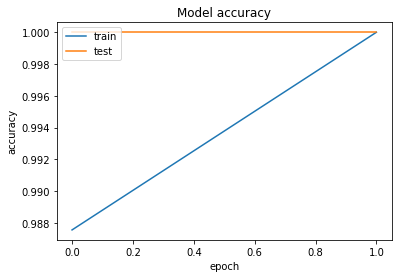

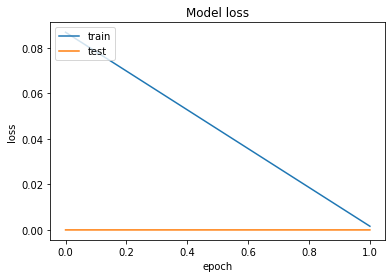

In [12]:
def plot_train_history(history1):
    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

plot_train_history(history)

In [13]:
path_test = f"/content/test.zip"

local_zip = path_test
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/')
zip_ref.close()

In [14]:
files = []
SOURCE = '/content/test/'
for filename in os.listdir(SOURCE):
    file = SOURCE + filename
    if os.path.getsize(file) > 0:
        files.append(filename)
    else:
        print(filename + " is zero length, so ignoring.")

00000030.jpg


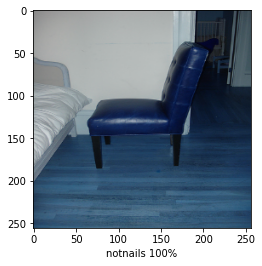

00000016.jpg


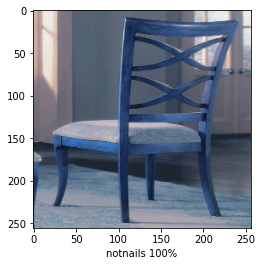

10-193.jpg


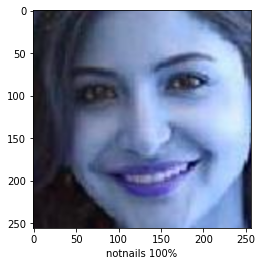

10-274.jpg


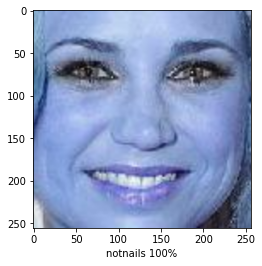

10-032.jpg


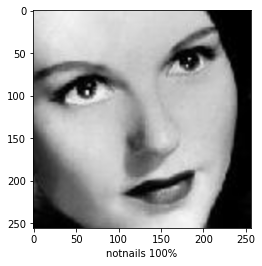

9-526.jpg


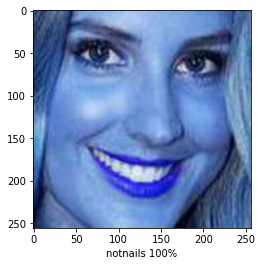

00000018.jpg


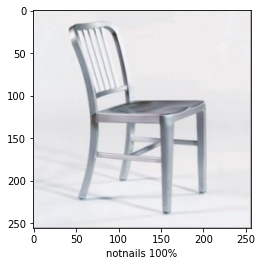

00000021.jpg


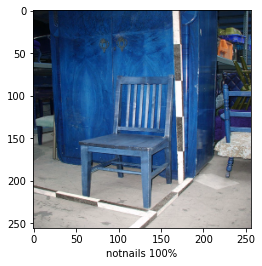

00000024.jpg


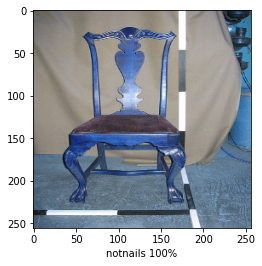

00000015.jpg


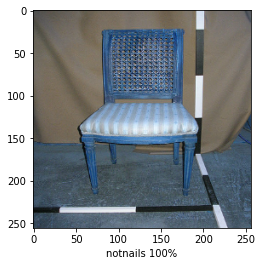

00000028.jpg


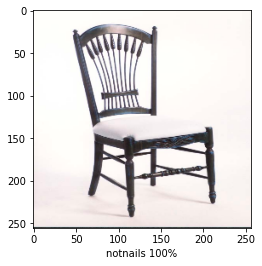

10-140.jpg


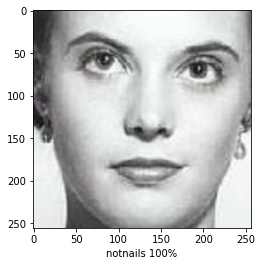

00000027.jpg


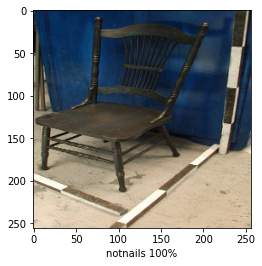

9-556.jpg


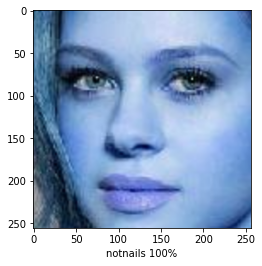

00000029.jpg


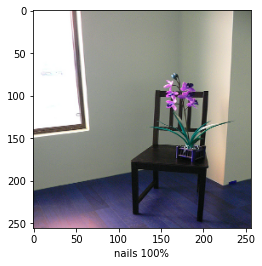

00000031.jpg


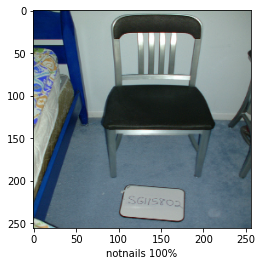

10-487.jpg


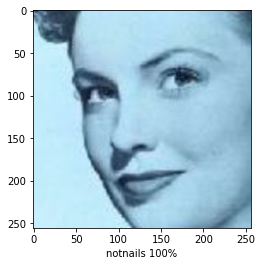

00000025.jpg


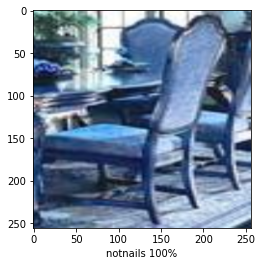

9-630.jpg


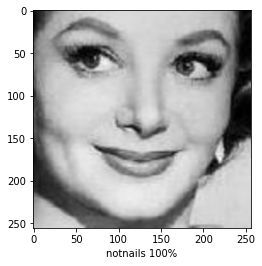

00000032.jpg


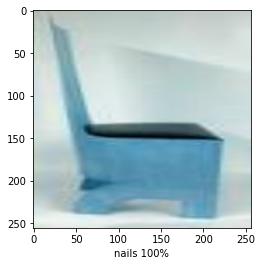

00000012.jpg


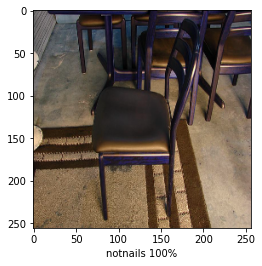

00000013.jpg


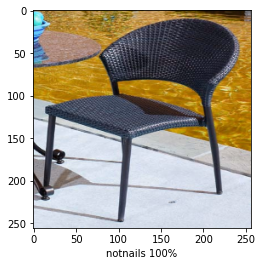

10-558.jpg


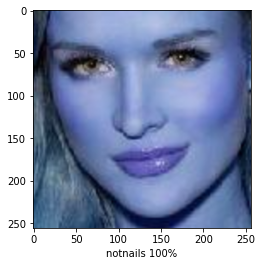

10-425.jpg


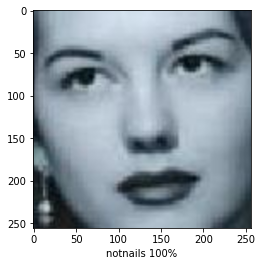

00000017.jpg


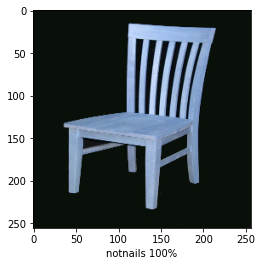

00000014.jpg


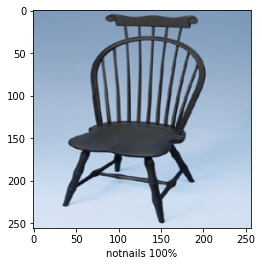

00000020.jpg


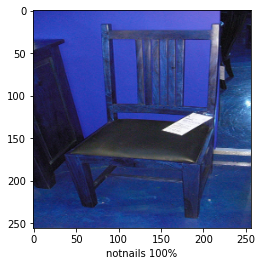

00000023.jpg


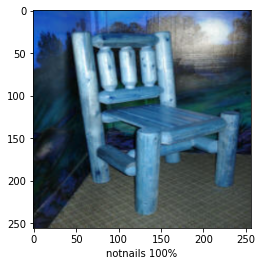

00000033.jpg


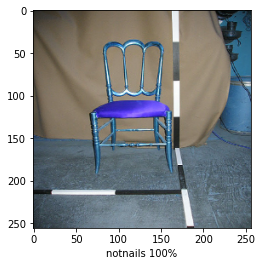

10-226.jpg


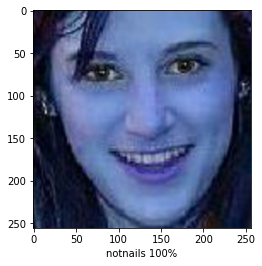

00000022.jpg


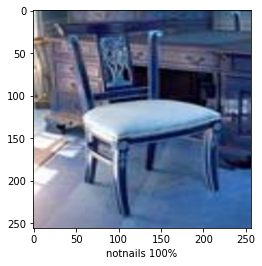

10-513.jpg


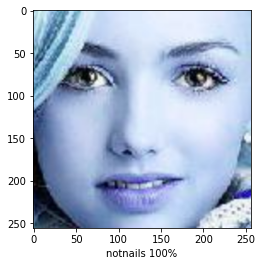

10-366.jpg


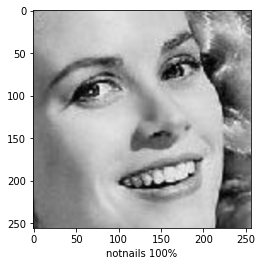

10-230.jpg


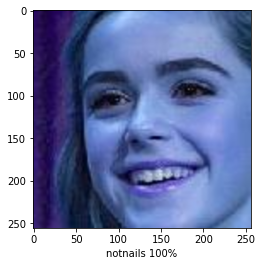

00000026.jpg


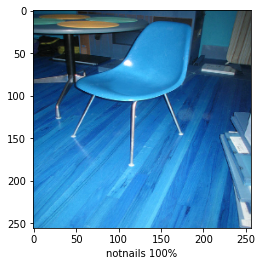

10-295.jpg


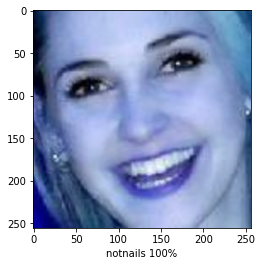

00000019.jpg


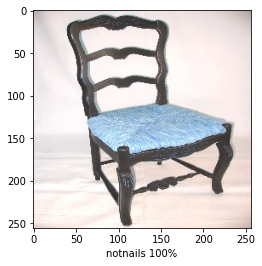

10-380.jpg


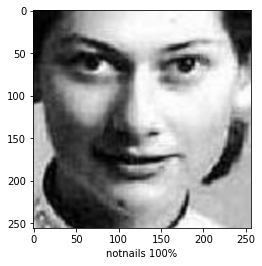

94.73684210526315% correct


In [20]:
count = 0
count2 = 0
for file in files:
  count += 1
  path = SOURCE + file
  image = cv2.imread(path)
  image = cv2.resize(image, (IMGSIZE, IMGSIZE))
  img = np.array(image).reshape(-1, IMGSIZE, IMGSIZE, 3)
  img = img/255.
  xy = img
  xy = np.expand_dims(img, axis=-1)
  images = np.vstack([xy])
  predictions = model.predict([images], batch_size=32)


  print(file)
  imgplot = plt.imshow(image)
  plt.xlabel("{} {:2.0f}%".format(CATEGORIES[int(predictions[0][0])],
                             100*(np.max(predictions))))
  
  if(CATEGORIES[int(predictions[0][0])] == "notnails"):
    count2 += 1

  plt.show()

print("{}% correct".format(count2/count*100))

In [21]:
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

Saving kuku.jpg to kuku (6).jpg


10-380.jpg


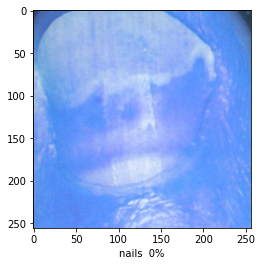

In [24]:
for fn in uploaded.keys():
 
  # predicting images
  path = fn
  image = cv2.imread(path)
  image = cv2.resize(image, (IMGSIZE, IMGSIZE))
  img = np.array(image).reshape(-1, IMGSIZE, IMGSIZE, 3)
  img = img/255.
  xy = img
  xy = np.expand_dims(img, axis=-1)
  images = np.vstack([xy])
  predictions = model.predict([images])


  print(file)
  imgplot = plt.imshow(image)
  plt.xlabel("{} {:2.0f}%".format(CATEGORIES[int(predictions[0][0])],
                             100*(np.max(predictions))))

  plt.show()